In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.warn("deprecated", DeprecationWarning)

### Train Data exploration and visualization

In [2]:
df_train = pd.read_csv('train.csv')
df_train.shape

(404290, 6)

In [3]:

# df_train = df_train.loc[np.random.random_integers(0, len(df_train), 5000)]
# len(df_train)

In [4]:
qids = pd.Series(df_train['qid1'].tolist()+df_train['qid2'].tolist())

In [5]:
unique_qid = set(qids)
unique_qsts = len(unique_qid)
qs_morethan_onetime= sum(qids.value_counts()>1)
qs_morethan_onetime

111780

In [6]:
  df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
#check how many questions with any null value
nan_count = df_train[df_train.isnull().any(1)]
nan_count

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
df_train[df_train.isnull().any(1)]
df_train = df_train.fillna('') #Fill null values with '' string

In [9]:
#Re-check how many questions with any null value
nan_count = df_train[df_train.isnull().any(1)]
nan_count #Finally the we found the question with no null values 

,id,qid1,qid2,question1,question2,is_duplicate


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
df_train.groupby("is_duplicate")['id'].count() #count the number of 'duplicate' and 'non-duplicate' question

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

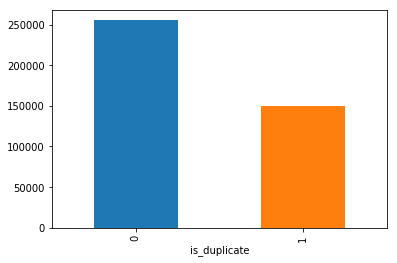

In [12]:
df_train.groupby("is_duplicate")['id'].count().plot.bar() #plot the graph for the above data

In [13]:
is_duplicate0 = len(df_train[df_train['is_duplicate']==0])
is_duplicate0/len(df_train)
print("Percentage of non-Duplicate Questions: %d percentage"%((is_duplicate0/len(df_train))*100))

Percentage of non-Duplicate Questions: 63 percentage


In [14]:
is_duplicate1 = len(df_train[df_train['is_duplicate']==1])
is_duplicate1/len(df_train)

print("Percentage of Duplicate Questions: %d percentage"%((is_duplicate1/len(df_train))*100))

Percentage of Duplicate Questions: 36 percentage


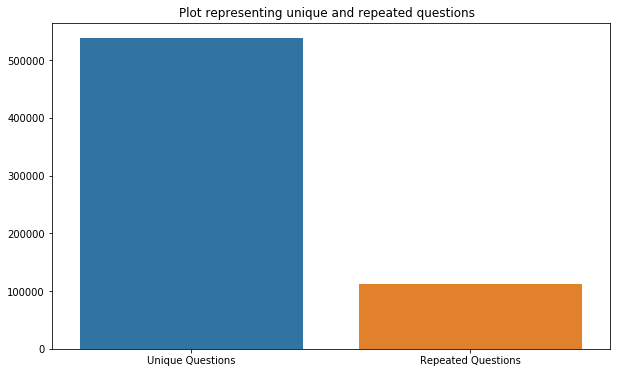

In [15]:
x = ["Unique Questions" , "Repeated Questions"]
y =  [unique_qsts , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [16]:
#Check whether there are any repeated pair of questions
pair_duplicates  = df_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('Total Number of pair_duplicates groups: ',pair_duplicates.shape[0])
print('Total Number of row: ',df_train.shape[0]) #If both count are equal then there are no duplicates
print("Total duplicate pairs: ",(df_train.shape[0] - pair_duplicates.shape[0]))

Total Number of pair_duplicates groups:  404290
Total Number of row:  404290
Total duplicate pairs:  0


### Overall info about train Data

In [17]:
print('Total number of question pairs in training dataset: ', len(df_train))
print('Total number of unique questions in training dataset: ', len(unique_qid))
print("In Train dataset: ")
print('Total percentage of is_duplicate=0: ', round((is_duplicate0/(is_duplicate0+is_duplicate1))*100, 2), "%")
print('Total percentage of is_duplicate=1: ', round((is_duplicate1/(is_duplicate0+is_duplicate1))*100, 2), "%")

Total number of question pairs in training dataset:  404290
Total number of unique questions in training dataset:  537933
In Train dataset: 
Total percentage of is_duplicate=0:  63.08 %
Total percentage of is_duplicate=1:  36.92 %


###  Feature extraction 

1. **q1_len** = Length of Question-1
2. **q2_len** = Length of Question-2
3. **q1_no_words** = Number of words in Question-1
4. **q2_no_words** = Number of words in Question-2
5. **total_uni_words** = Total number of unique words in Question-1 and Question-2, Combine and find unique.
6. **common_words** = Total number of common words in both Question-1 and Question-2
7. **word_share** = Total number of words share(common_words/total_words)
8. **total_words** = Total number of words unique words in Question-1 and Question-2, find Unique in each and add them.

In [18]:
df_train['q1_len'] = df_train['question1'].str.len()
df_train['q2_len'] = df_train['question2'].str.len()
df_train['q1_no_words'] = df_train['question1'].apply(lambda row: len(row.split()))
df_train['q2_no_words'] = df_train['question2'].apply(lambda row: len(row.split()))

df_train['q1_uni'] = df_train.apply(lambda row: len(set(row['question1'].lower().strip().split())), axis=1)
df_train['q2_uni'] = df_train.apply(lambda row: len(set(row['question2'].lower().strip().split())), axis=1)
df_train['avg_uwc'] = df_train.apply(lambda row: (row['q1_uni']+row['q2_uni'])/2.0, axis=1)
def total_uni_words(row):
    q1_w = row['question1'].lower().strip().split()
    q2_w = row['question2'].lower().strip().split()
    total_w = len(set(q1_w + q2_w))
    return total_w
df_train['total_uni_words'] = df_train.apply(total_uni_words, axis=1)

def total_words(row):
    q1_w = set(row['question1'].lower().strip().split())
    q2_w = set(row['question2'].lower().strip().split())
    total_w = len(q1_w)+ len(q2_w)
    return total_w

df_train['total_words'] = df_train.apply(total_words, axis=1)

def common_words(row):
    q1_w = set(row['question1'].lower().strip().split())
    q2_w = set(row['question2'].lower().strip().split())
    common_w = len(q1_w.intersection(q2_w)) #find common between two sets
#     x = set(["a","b","c","d"])
#     y = set(["c","d", 'f'])
#     print( y.intersection(x) )
#     outPut: {'c', 'd'}
    return common_w
df_train['common_words'] = df_train.apply(common_words, axis=1)   

def word_share(row):
    w_share = row['common_words']/row['total_words']
    return 1.0*w_share
    
df_train['word_share'] = df_train.apply(word_share, axis=1)   



df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_no_words,q2_no_words,q1_uni,q2_uni,avg_uwc,total_uni_words,total_words,common_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,12,11,11.5,13,23,10,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,8,12,10.0,16,20,4,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,14,10,12.0,20,24,4,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,10,9,9.5,19,19,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,13,7,10.0,18,20,2,0.100000


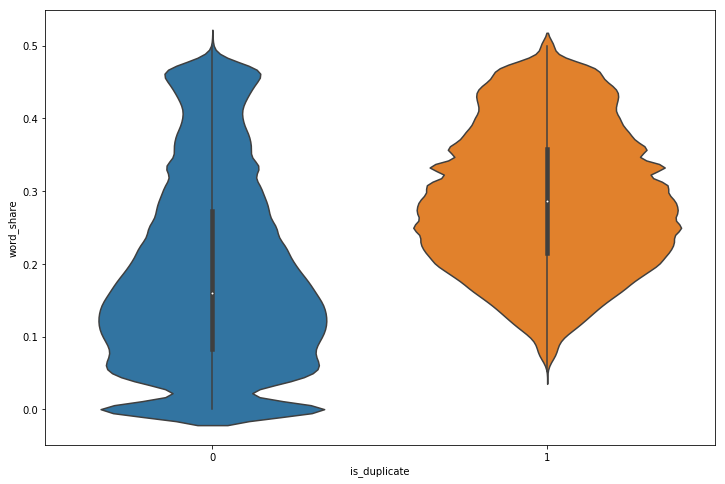

In [19]:
plt.figure(figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df_train)

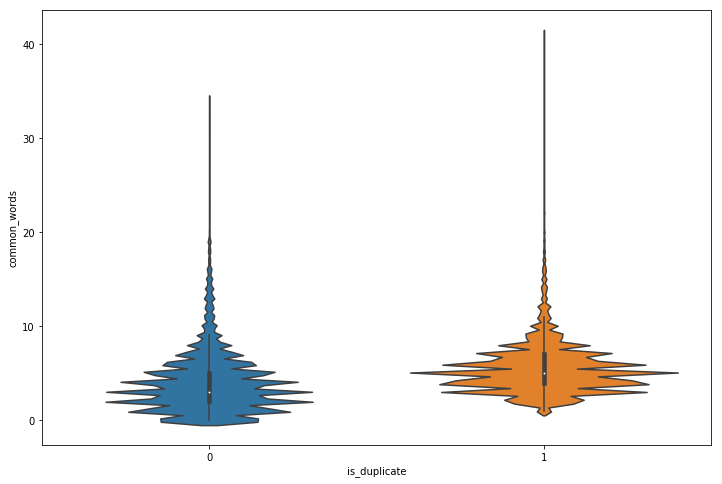

In [20]:
plt.figure(figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y = 'common_words', data = df_train)

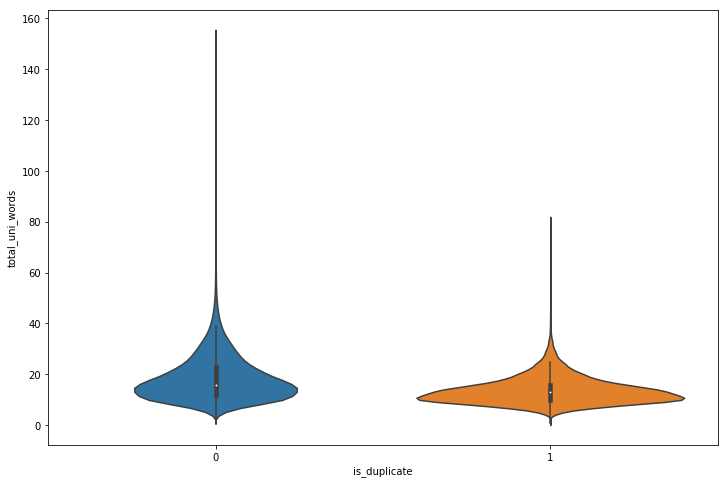

In [21]:
plt.figure(figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y = 'total_uni_words', data = df_train)

In [22]:
#Some Analysis of extracted feature

print("Shortest length of the question in Question-1: %d"%min(df_train['q1_no_words']))
print("Shortest length of the question in Question-2:  %d"%min(df_train['q2_no_words']))

Shortest length of the question in Question-1: 0
Shortest length of the question in Question-2:  0


In [23]:
df_train = df_train[df_train['q1_no_words']>0]
df_train = df_train[df_train['q2_no_words']>0]
print("Shortest length of the question in Question-1: %d"%min(df_train['q1_no_words']))
print("Shortest length of the question in Question-2:  %d"%min(df_train['q2_no_words']))

Shortest length of the question in Question-1: 1
Shortest length of the question in Question-2:  1


In [24]:
# Now find how many number of questions with min length
print("Total number of question with min length in Question-1: ",df_train[df_train['q1_no_words']==1].shape[0])
print("Total number of question with min length in Question-2: ",df_train[df_train['q2_no_words']==1].shape[0])

Total number of question with min length in Question-1:  69
Total number of question with min length in Question-2:  25


### PreProcessing the text

In [25]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
stop_words = stopwords.words("english")

In [ ]:

def preProcess(x):
    x = str(x).lower()
    x = x.replace("won't", "will not")\
            .replace("cannot", "can not")\
            .replace("can't", "can not")\
            .replace("n't", " not")\
            .replace("what's", "what is")\
            .replace("it's", "it is")\
            .replace("i'm", "i am")\
            .replace("'re", " are")\
            .replace("%", " percent ")\
            .replace("€", " euro ")\
            .replace("'ll", " will")\
            .replace(",000,000", "m")\
            .replace(",000", "k")
    
    porter = PorterStemmer()
    if type(x) == type(''):
        x = porter.stem(x)
        temp = BeautifulSoup(x)
        x = temp.get_text()
#     print(x)
    return x

In [ ]:
df_train['question1'] = df_train["question1"].fillna("").apply(preProcess)

In [ ]:
df_train['question1'].head()

In [ ]:
df_train['question2'] = df_train["question2"].fillna("").apply(preProcess)

In [ ]:
df_train['avg_len'] = df_train.apply(lambda row: (row['q1_len']+row['q2_len'])/2.0 , axis=1)
df_train['cwc_min'] = df_train.apply(lambda row: row['common_words']/(min(row['q1_len'], row['q2_len'])) , axis=1)
df_train['cwc_max'] = df_train.apply(lambda row: row['common_words']/(max(row['q1_len'], row['q2_len'])) , axis=1)
df_train['is_fw_same'] = df_train.apply(lambda row: (row['question1'].lower().strip().split()[0] == row['question2'].lower().strip().split()[0]) , axis=1)
df_train['is_lw_same'] = df_train.apply(lambda row: (row['question1'].lower().strip().split()[-1] == row['question2'].lower().strip().split()[-1]) , axis=1)

df_train['cwc_min'] = df_train.apply(lambda row: row['common_words']/(min(row['q1_len'], row['q2_len'])) , axis=1)
df_train['cwc_max'] = df_train.apply(lambda row: row['common_words']/(min(row['q1_len'], row['q2_len'])) , axis=1)

In [ ]:
df_train.head()

### Feature Extraction from fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


Definations

1. Simple Ratio: Compare two sequences and produce the ratio of those two
2. Partial Ratio: Find the max
3. Token Sort Ratio: The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and then joining them back into a string. 
4. Token Set Ratio: we tokenize both strings, but instead of immediately sorting and comparing, we split the tokens into two groups: intersection and remainder. We use those sets to build up a comparison string.



In [ ]:
def fuzzy_features(row):
    simple_ratio = fuzz.ratio(row['question1'],row['question2'])
    partial_ratio =  fuzz.partial_ratio(row['question1'],row['question2'])
    token_sort_ratio = fuzz.token_sort_ratio(row['question1'],row['question2'])
    token_set_ratio =  fuzz.token_set_ratio(row['question1'],row['question2'])
    partial_token_set_ratio = fuzz.partial_token_set_ratio(row['question1'],row['question2'])
    partial_token_sort_ratio = fuzz.partial_token_sort_ratio(row['question1'],row['question2'])
    
    return [simple_ratio, partial_ratio, token_sort_ratio, token_set_ratio, partial_token_set_ratio,partial_token_sort_ratio]

In [ ]:
fuzzy_features = df_train.apply(fuzzy_features, axis=1)

In [ ]:
from difflib import SequenceMatcher
import math
df_train['difflib_similarity'] = df_train.apply(lambda x: SequenceMatcher(None, str(x['question1']), str(x['question2'])).ratio(), axis=1)

# Compute Jaccard Similarity Score 
def jaccard_similarity_str(row):
    intersection_cardinality = len(set.intersection(*[set(row['question1']), set(row['question2'])]))
    union_cardinality = len(set.union(*[set(row['question1']), set(row['question2'])]))
    return intersection_cardinality/float(union_cardinality)
def cosine_similarity_str(row):
    intersection_cardinality = len(set.intersection(*[set(row['question1']), set(row['question2'])]))
    sqrt_product = math.sqrt(len(row['question1'])) * math.sqrt(len(row['question2']))
    return intersection_cardinality/float(sqrt_product)
df_train['jaccard_similarity_str'] = df_train.apply(jaccard_similarity_str, axis=1)
df_train['cosine_similarity_str'] = df_train.apply(cosine_similarity_str, axis=1)


# jacard_score =  len(common_words)/(len(q1_words) + len(q2_words) - len(common_words))  
# cosine_score = len(common_words)/(pow(len(q1_words),0.5)*pow(len(q2_words),0.5))

In [ ]:
# fuzzy_features.values
temp = np.vstack(fuzzy_features.values)
df_train['simple_ratio'] = temp[:,0]
df_train['partial_ratio'] = temp[:,1]
df_train['token_sort_ratio'] = temp[:,2]
df_train['token_set_ratio'] = temp[:,3]
df_train['partial_token_set_ratio'] = temp[:,4]
df_train['partial_token_sort_ratio'] = temp[:,5]

In [ ]:
df_train.head()

### Analyzing the extracted features

In [ ]:
df_duplicate = df_train[df_train['is_duplicate'] == 1]
df_non_duplicate = df_train[df_train['is_duplicate'] == 0]

In [ ]:
duplicate_array = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
non_duplicate_array = np.dstack([df_non_duplicate["question1"], df_non_duplicate["question2"]]).flatten()

In [ ]:
text_dulicate = " ".join(duplicate_array)
text_non_dulicate = " ".join(non_duplicate_array)

In [ ]:
from wordcloud import WordCloud

In [ ]:
wc = WordCloud(background_color="white", max_words=len(text_dulicate), stopwords=stop_words)
wc.generate(text_dulicate)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(16, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
wc = WordCloud(background_color="white", max_words=len(text_non_dulicate), stopwords=stop_words)
wc.generate(text_non_dulicate)
print ("Word Cloud for non Duplicate Question pairs")
plt.figure(figsize=(16, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# we convert all the features into numaric before we apply any model
# ['id', 'qid1', 'qid2', 'question1', 'question2']
cols = list(df_train.columns)
for i in cols:
    if i not in ['id', 'qid1', 'qid2', 'question1', 'question2']:
        df_train[i] = df_train[i].apply(pd.to_numeric)
        print(i)

In [ ]:
import seaborn as sns
cor = df_train[['q1_len', 'q2_len', 'q1_no_words', 'q2_no_words','is_fw_same','is_lw_same', 'total_uni_words', 'total_words','difflib_similarity', 'common_words', 'word_share', 'simple_ratio', 'partial_ratio', 'token_sort_ratio', 'token_set_ratio','partial_token_sort_ratio','partial_token_set_ratio', 'is_duplicate']].corr()
sns.set(font_scale=1.25)
plt.figure(figsize=(16,9))
hm = sns.heatmap(cor, cbar=True, annot=True, square=True,cmap="YlGnBu",
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=list(cor.columns), xticklabels=list(cor.columns))
plt.suptitle(' Correlations Heat Map for attributes', fontsize=16, fontweight='bold')
plt.show()


# # ref: https://www.kaggle.com/fg1983/data-exploration-and-price-prediction-house-sales

In [ ]:
df_train.head()

### Random train test split

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
# define tfidf vectorizer 
tfidf = TfidfVectorizer(analyzer = 'word',token_pattern=r'\w{1,}',
                        ngram_range=(1,2),use_idf=1,smooth_idf=1,sublinear_tf=1,
                        stop_words = 'english',
                        lowercase = True,
                        max_features = None,
                        norm = 'l1')

In [ ]:
# text_dulicate
s1 = pd.Series(df_train['question1'].tolist())
s2 = pd.Series(df_train['question2'].tolist())
BagOfWords = pd.concat([s1, s2])

In [ ]:
tfidf.fit(BagOfWords)

In [ ]:
train_q1_tfidf = tfidf.transform(df_train['question1'])
train_q2_tfidf = tfidf.transform(df_train['question2'])

In [ ]:
df_train.columns

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import f1_score
from termcolor import colored

In [ ]:
bf = ['q1_len', 'q2_len', 'q1_no_words', 'q2_no_words', 'q1_uni', 'q2_uni','avg_uwc', 'total_uni_words', 'total_words', 'common_words','word_share', 'avg_len','is_fw_same', 'is_lw_same']
ff = ['q1_len', 'q2_len', 'q1_no_words', 'q2_no_words', 'q1_uni', 'q2_uni','avg_uwc', 'total_uni_words', 'total_words', 'common_words', 'word_share', 'avg_len', 'cwc_min', 'cwc_max', 'is_fw_same', 'is_lw_same', 'simple_ratio', 'partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'partial_token_set_ratio', 'partial_token_sort_ratio']
af  =['q1_len', 'q2_len', 'q1_no_words', 'q2_no_words', 'q1_uni', 'q2_uni', 'avg_uwc', 'total_uni_words', 'total_words', 'common_words','word_share', 'avg_len', 'cwc_min', 'cwc_max', 'is_fw_same', 'is_lw_same', 'difflib_similarity', 'simple_ratio', 'partial_ratio','token_sort_ratio', 'token_set_ratio', 'partial_token_set_ratio','partial_token_sort_ratio', 'jaccard_similarity_str','cosine_similarity_str']
features = {"0": bf, "1": ff, "2": af}

In [ ]:
y = df_train['is_duplicate']
for i in features:
    X = df_train[features[i]]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    print ('\n')
    print ('\n')
    print ('=================Start of Iter:%s================='%i)
    ## Logistic Regression
    print( "Logistic Regression Model for Classificatio:")
    LR = LogisticRegression(C=1.0, penalty='l1')
    LR.fit(X_train, y_train)
    y_preds = LR.predict(X_valid)
    print( "Logistic Regression Model predictive accuracy:",colored(metrics.accuracy_score(y_preds, y_valid), 'green'))
    print ("Logistic Regression Model  F1 score:", metrics.classification_report(y_preds, y_valid))
    print ("Logistic Regression Model log loss:", metrics.log_loss(y_preds, y_valid))
    print ('\n')

    print ("Gaussian Naive Bayes Model for Classificatio:")
    GNB = GaussianNB()
    GNB.fit(X_train, y_train)
    y_preds = GNB.predict(X_valid)
    print ("Gaussian Naive Bayes Model predictive accuracy:", colored(metrics.accuracy_score(y_preds, y_valid), 'green'))
    print ("Gaussian Naive Bayes Model  F1 score:", metrics.classification_report(y_preds, y_valid))
    print ("Gaussian Naive Bayes Model log loss:", metrics.log_loss(y_preds, y_valid))
    print ('\n')

    print ("Support Vector Machines Model for Classificatio:")
    sv = svm.SVC(C=1.0, kernel='linear')
    sv.fit(X_train, y_train)
    y_preds = sv.predict(X_valid)
    print ("Support Vector Machine Model predictive accuracy:", colored(metrics.accuracy_score(y_preds, y_valid), 'green'))
    print ("Support Vector Machine F1 score:", metrics.classification_report(y_preds, y_valid))
    print ("Support Vector Machine log loss:", metrics.log_loss(y_preds, y_valid))
    print( '\n')

    print ("Random Forest Model for Classification:")
    RF = RandomForestClassifier(n_estimators=100, max_depth=10, criterion = 'entropy')
    RF.fit(X_train, y_train)
    y_preds = RF.predict(X_valid)
    print ("Random Forest Classifier Model predictive accuracy:", colored(metrics.accuracy_score(y_preds, y_valid), 'green'))
    print ("Random Forest Classifier F1 score:", metrics.classification_report(y_preds, y_valid))
    print ("Random Forest Classifier log loss:", metrics.log_loss(y_preds, y_valid))
    print ('\n')

    print ("XGboost Model for Classification:")
    model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)\
        .fit(X_train, y_train.values.ravel()) 
    y_preds = model.predict(X_valid)
    print ("XGboost Classifier Model predictive accuracy:", colored(metrics.accuracy_score(y_preds, y_valid), 'green'))
    print ("XGboost Classifier F1 score:", metrics.classification_report(y_preds, y_valid))
    print ("XGboost Classifier log loss:", metrics.log_loss(y_preds, y_valid))
    print ('=================End of Iter:%s================='%i)